# Lesson: 6_Quantification_Statistical Analysis

## Objectives
- Perform statistical analysis of neuroanatomical phenotypes
- Visualize stat maps

In [27]:
import os
import glob
import numpy as np
import pandas as pd
import nilearn
from nilearn import plotting
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib

/opt/conda/shared/envs/ni38/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [28]:
%matplotlib inline

## Quantifying tissue properties

### Get data

In [3]:
from bids import BIDSLayout

In [168]:
data_dir = '../local_data/AOMIC'
fmriprep_dir = '../local_data/AOMIC/derivatives/fs_stats'
fsstats_dir = '../local_data/AOMIC/derivatives/fs_stats'
proc_dir = '../local_data/AOMIC/derivatives/smri_course'

In [4]:
bids_layout = BIDSLayout(data_dir, derivatives=True)
bids_layout

/opt/conda/shared/envs/ni38/lib/python3.8/site-packages/bids/layout/models.py:148: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  warnings.warn("The 'extension' entity currently excludes the leading dot ('.'). "


BIDS Layout: ...SDC-BIDS-sMRI/local_data/AOMIC | Subjects: 2 | Sessions: 0 | Runs: 0

### Metric from volumetric data: region volumes

In [31]:
t1_file = bids_layout.get(subject="0001", scope="derivatives", datatype='anat', desc='preproc',
                          extension='nii.gz', return_type='filename')[0]
t1 = nib.load(t1_file)

Let's measure the volume of the right caudate region of our subject, from the subcortical segmentation obtained from Freesurfer.

In [25]:
t1_aseg_file = bids_layout.get(subject="0001", scope="derivatives", 
                               datatype='anat', suffix='dseg',
                               desc="aseg", extension='nii.gz', return_type='filename')[0]

In [29]:
t1_aseg = nib.load(t1_aseg_file)
t1_aseg_data = t1_aseg.get_fdata()

According to the Freesurfer legend (link), the ROI of interest has intensity 50.

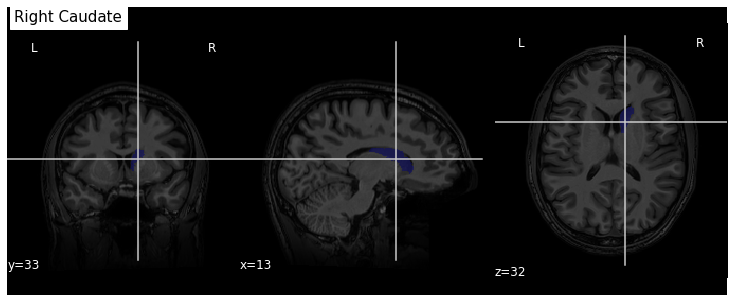

In [33]:
roi_ix = 50
roi_mask_arr = (t1_aseg_data == roi_ix)
roi_mask_int = nib.Nifti1Image(roi_mask_arr.astype(int), affine=t1_aseg.affine)
fig = plt.figure(figsize=(10, 4))
plotting.plot_roi(roi_img=roi_mask_int, bg_img=t1, alpha=0.4, title='Right Caudate', figure=fig);

We can get the number of voxels by counting them in the mask:

In [34]:
caudate_R_n_vox = roi_mask_arr.sum()
caudate_R_n_vox

3854

However we have to take into account voxel sizes in standard unit:

In [42]:
t1.header.get_zooms()

(1.0, 1.0, 1.0)

In [43]:
vox_size = np.array(t1.header.get_zooms()).prod()
vox_size

1.0

The volume of interest in mm3 is then:

In [44]:
caudate_R_vol_mm3 = caudate_R_n_vox * vox_size
caudate_R_vol_mm3

3854.0

Or, since there is always a python module for anything:

In [45]:
import nibabel.imagestats as imagestats
# Volume of the Left hippocampus
imagestats.mask_volume(roi_mask_int)

3854.0

### Metric from surface data with Freesurfer: cortical thickness

Freesurfer output by default several files to quantify both volume and surface data of each subject. After processing with smriprep/fmriprep, these files can be found in `derivatives/freesurfer/stats`.

In [78]:
fs_rawstats_dir = "../local_data/AOMIC/derivatives/freesurfer/sub-0001/stats"

In [79]:
os.listdir(fs_rawstats_dir)

['lh.BA_exvivo.thresh.stats',
 'rh.aparc.a2009s.stats',
 'rh.aparc.pial.stats',
 'rh.aparc.DKTatlas.stats',
 'lh.curv.stats',
 'lh.w-g.pct.stats',
 'wmparc.stats',
 'lh.aparc.stats',
 'rh.BA_exvivo.thresh.stats',
 'rh.BA_exvivo.stats',
 'rh.w-g.pct.stats',
 'lh.aparc.pial.stats',
 'lh.BA_exvivo.stats',
 'rh.curv.stats',
 'aseg.stats',
 'lh.aparc.DKTatlas.stats',
 'lh.aparc.a2009s.stats',
 'rh.aparc.stats']

`aseg` is for subcortical volumetric regions ("segmentation" in Freesurfer-speak) and `aparc` for cortical surface regions ("parcellation" in Freesurfer-speak). `aparc.stats` is for the Desikan-Killiany atlas while `aparc.a2009s.stats` is for the Destrieux atlas (more regions). 

Let's take a peek at the data output by Freesurfer before jumping to the clean group aggregated data 

In [63]:
from itertools import islice
n_lines = 75
with open(os.path.join(fs_rawstats_dir, "lh.aparc.a2009s.stats")) as fs_stats_file:
    first_n_lines = list(islice(fs_stats_file, n_lines))

In [64]:
first_n_lines

['# Table of FreeSurfer cortical parcellation anatomical statistics \n',
 '# \n',
 '# CreationTime 2019/03/02-22:05:09-GMT\n',
 '# generating_program mris_anatomical_stats\n',
 '# cvs_version $Id: mris_anatomical_stats.c,v 1.79 2016/03/14 15:15:34 greve Exp $\n',
 '# mrisurf.c-cvs_version $Id: mrisurf.c,v 1.781.2.6 2016/12/27 16:47:14 zkaufman Exp $\n',
 '# cmdline mris_anatomical_stats -th3 -mgz -cortex ../label/lh.cortex.label -f ../stats/lh.aparc.a2009s.stats -b -a ../label/lh.aparc.a2009s.annot -c ../label/aparc.annot.a2009s.ctab sub-0001 lh white \n',
 '# sysname  Linux\n',
 '# hostname d8c6a608d514\n',
 '# machine  x86_64\n',
 '# user     root\n',
 '# \n',
 '# SUBJECTS_DIR /out/freesurfer\n',
 '# anatomy_type surface\n',
 '# subjectname sub-0001\n',
 '# hemi lh\n',
 '# AnnotationFile ../label/lh.aparc.a2009s.annot\n',
 '# AnnotationFileTimeStamp 2019/03/02 22:05:03\n',
 '# Measure Cortex, NumVert, Number of Vertices, 134288, unitless\n',
 '# Measure Cortex, WhiteSurfArea, White S

The value of the cortical thickness at each vertex of the mesh (before averaging in each ROI) is also made available by freesurfer. Plotting the cortical thickness for the left hemisphere is then obtained by adding the overlay of thickness measures to our previous surface mesh: 

In [76]:
fs_surf_dir = "../local_data/AOMIC/derivatives/freesurfer/sub-0001/surf"
lh_sulcus = os.path.join(fs_surf_dir, "lh.sulc")
lh_pial = os.path.join(fs_surf_dir, "lh.pial")
lh_thickness = os.path.join(fs_surf_dir, "lh.thickness")

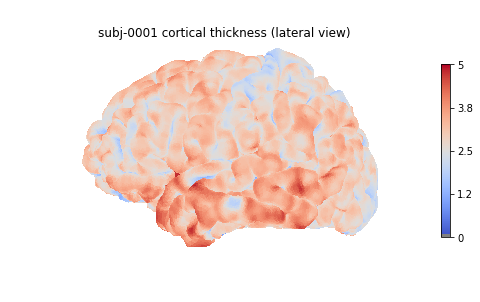

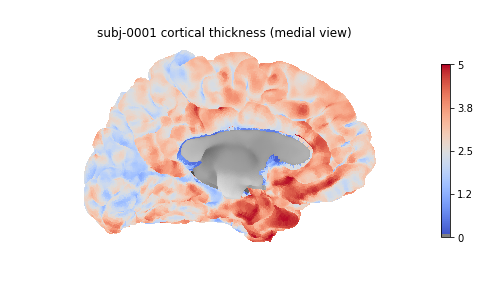

In [77]:
plotting.plot_surf(lh_pial, surf_map=lh_thickness, hemi='left', view='lateral', colorbar=True,
                    bg_map=lh_sulcus, cmap='coolwarm', vmin=0, threshold = 0.1,
                    title='subj-0001 cortical thickness (lateral view)');
plotting.plot_surf(lh_pial, surf_map=lh_thickness, hemi='left', view='medial', colorbar=True,
                    bg_map=lh_sulcus, cmap='coolwarm', vmin=0, threshold = 0.1,
                    title='subj-0001 cortical thickness (medial view)');

#### How to generate FS stats from FS files ?

* Step 1: convert from Freesurfer output files format to table format with Freesurfer
    * Cf [this bash script](https://github.com/NILAB-UvA/AOMIC-common-scripts/blob/master/fs_stats/create_freesurfer_tables.sh)
* Step 2: group individual subject measures to a single group file
    * Cf [this python code snippet](https://github.com/NILAB-UvA/AOMIC-common-scripts/blob/master/fs_stats/fs_stats.ipynb)

#### Starting from the group data

In our case we will get directly clean aggregated data for all our subjects.

In [80]:
fs_stats_dir = "../local_data/AOMIC/derivatives/fs_stats"

In [81]:
hemi="lh"

In [84]:
stats_file = os.path.join(fs_stats_dir, 
                          f"data-cortical_type-aparc.a2009s_measure-thickness_hemi-{hemi}.tsv")

In [86]:
fs_df = pd.read_csv(stats_file,sep='\t')
fs_df

,lh.aparc.a2009s.thickness,lh_G&S_frontomargin_thickness,lh_G&S_occipital_inf_thickness,lh_G&S_paracentral_thickness,lh_G&S_subcentral_thickness,lh_G&S_transv_frontopol_thickness,lh_G&S_cingul-Ant_thickness,lh_G&S_cingul-Mid-Ant_thickness,lh_G&S_cingul-Mid-Post_thickness,lh_G_cingul-Post-dorsal_thickness,...,lh_S_precentral-inf-part_thickness,lh_S_precentral-sup-part_thickness,lh_S_suborbital_thickness,lh_S_subparietal_thickness,lh_S_temporal_inf_thickness,lh_S_temporal_sup_thickness,lh_S_temporal_transverse_thickness,lh_MeanThickness_thickness,BrainSegVolNotVent,eTIV
0,sub-0001,1.925,2.517,2.266,2.636,2.600,2.777,2.606,2.736,2.956,...,2.719,2.302,2.417,2.514,2.485,2.462,2.752,2.56319,1235952.0,1.560839e+06
1,sub-0002,2.405,2.340,2.400,2.849,2.724,2.888,2.658,2.493,3.202,...,2.248,2.342,3.264,2.619,2.212,2.386,2.772,2.45903,1056970.0,1.115228e+06
2,sub-0003,2.477,2.041,2.255,2.648,2.616,2.855,2.924,2.632,2.984,...,2.489,2.276,2.130,2.463,2.519,2.456,2.685,2.53883,945765.0,1.186697e+06
3,sub-0004,2.179,2.137,2.366,2.885,2.736,2.968,2.576,2.593,3.211,...,2.399,2.145,2.920,2.790,2.304,2.564,2.771,2.51093,973916.0,9.527770e+05
4,sub-0005,2.483,2.438,2.219,2.832,2.686,3.397,2.985,2.585,3.028,...,2.569,2.352,3.598,2.331,2.494,2.665,2.538,2.53830,1089881.0,1.497743e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,sub-0222,2.429,2.353,2.240,2.754,2.837,2.886,2.659,2.541,2.848,...,2.468,2.278,2.861,2.383,2.511,2.371,2.453,2.40305,1024683.0,1.187630e+06
222,sub-0223,1.950,2.165,2.331,2.578,2.444,2.765,2.641,2.641,2.953,...,2.249,2.420,2.886,2.361,2.360,2.481,2.192,2.44357,1080928.0,1.210314e+06
223,sub-0224,2.231,2.518,2.137,2.440,2.578,2.809,2.833,2.645,3.084,...,2.487,2.368,2.611,2.636,2.731,2.410,2.377,2.46291,1140289.0,1.302062e+06
224,sub-0225,2.513,2.495,2.141,2.492,2.757,2.553,2.238,2.684,3.065,...,2.479,2.304,2.870,2.275,2.481,2.533,2.009,2.43156,1080245.0,1.395822e+06


Collect data for the Destrieux atlas for left and right hemisphere

In [95]:
fs_df = pd.DataFrame()
for hemi in ['lh','rh']:
    stats_file = os.path.join(fs_stats_dir, 
                              f"data-cortical_type-aparc.a2009s_measure-thickness_hemi-{hemi}.tsv")
    fs_hemi_df = pd.read_csv(stats_file,sep='\t')
    # Rename columns to concat multiple cohorts / hemis and remove verbose freesurfer suffixes
    orig_cols = list(fs_hemi_df.columns)
    roi_and_mean_cols = []
    for col in orig_cols[1:-2]:
        roi_name_with_special_chars = col.split('_',1)[1].rsplit('_',1)[0]
        roi_name = roi_name_with_special_chars.replace('&', '_and_').replace('-', '_')
        roi_and_mean_cols.append(roi_name)                 
    renamed_cols = ['participant_id'] + roi_and_mean_cols
    old2new_roinames = dict(zip(orig_cols, renamed_cols))
    new2old_roinames = dict(zip(renamed_cols, orig_cols))
    fs_hemi_df = fs_hemi_df.rename(columns=old2new_roinames)
    fs_hemi_df['hemi'] = hemi
    fs_df = fs_df.append(fs_hemi_df)
    roi_cols = roi_and_mean_cols[:-1]
    print(f"Hemisphere: {hemi}, Number of ROIs: {len(roi_cols)}")
fs_df.head()

Hemisphere: lh, Number of ROIs: 74
Hemisphere: rh, Number of ROIs: 74


,participant_id,G_and_S_frontomargin,G_and_S_occipital_inf,G_and_S_paracentral,G_and_S_subcentral,G_and_S_transv_frontopol,G_and_S_cingul_Ant,G_and_S_cingul_Mid_Ant,G_and_S_cingul_Mid_Post,G_cingul_Post_dorsal,...,S_precentral_sup_part,S_suborbital,S_subparietal,S_temporal_inf,S_temporal_sup,S_temporal_transverse,MeanThickness,BrainSegVolNotVent,eTIV,hemi
0,sub-0001,1.925,2.517,2.266,2.636,2.600,2.777,2.606,2.736,2.956,...,2.302,2.417,2.514,2.485,2.462,2.752,2.56319,1235952.0,1.560839e+06,lh
1,sub-0002,2.405,2.340,2.400,2.849,2.724,2.888,2.658,2.493,3.202,...,2.342,3.264,2.619,2.212,2.386,2.772,2.45903,1056970.0,1.115228e+06,lh
2,sub-0003,2.477,2.041,2.255,2.648,2.616,2.855,2.924,2.632,2.984,...,2.276,2.130,2.463,2.519,2.456,2.685,2.53883,945765.0,1.186697e+06,lh
3,sub-0004,2.179,2.137,2.366,2.885,2.736,2.968,2.576,2.593,3.211,...,2.145,2.920,2.790,2.304,2.564,2.771,2.51093,973916.0,9.527770e+05,lh
4,sub-0005,2.483,2.438,2.219,2.832,2.686,3.397,2.985,2.585,3.028,...,2.352,3.598,2.331,2.494,2.665,2.538,2.53830,1089881.0,1.497743e+06,lh


### Demographics

In [18]:
subjects_info_withna = bids_layout.get(suffix="participants", extension=".tsv")[0].get_df()

In [19]:
subjects_info_withna

,participant_id,age,sex,BMI,handedness,education_category,raven_score,NEO_N,NEO_E,NEO_O,NEO_A,NEO_C
0,sub-0001,25.50,M,21.0,right,academic,33.0,23,40,52,47,32
1,sub-0002,23.25,F,22.0,right,academic,19.0,22,47,34,53,46
2,sub-0003,25.00,F,23.0,right,applied,29.0,26,42,37,48,48
3,sub-0004,20.00,F,18.0,right,academic,24.0,32,42,36,48,52
4,sub-0005,24.75,M,27.0,right,academic,24.0,32,51,41,51,53
...,...,...,...,...,...,...,...,...,...,...,...,...
221,sub-0222,22.00,F,20.0,right,academic,30.0,41,35,51,48,42
222,sub-0223,20.75,F,23.0,left,applied,26.0,33,41,54,36,41
223,sub-0224,21.75,M,20.0,right,academic,34.0,22,45,47,46,46
224,sub-0225,20.25,F,28.0,right,academic,27.0,48,32,43,42,37


#### Data cleaning

In [20]:
subjects_info.loc[subjects_info_withna.isnull().any(axis=1), :]

,participant_id,age,sex,BMI,handedness,education_category,raven_score,NEO_N,NEO_E,NEO_O,NEO_A,NEO_C
104,sub-0105,NaN,NaN,NaN,NaN,NaN,NaN,13,43,35,39,53
198,sub-0199,NaN,F,NaN,NaN,applied,16.0,41,52,41,46,59


In [21]:
subjects_info['age'].fillna(subjects_info['age'].mean(), inplace=True)
subjects_info['sex'].fillna(subjects_info['sex'].mode()[0], inplace=True)

In [96]:
demo_cols = ["participant_id", "age", "sex"]
fs_all_df = pd.merge(subjects_info[demo_cols], fs_df, on='participant_id')
fs_all_df

,participant_id,age,sex,G_and_S_frontomargin,G_and_S_occipital_inf,G_and_S_paracentral,G_and_S_subcentral,G_and_S_transv_frontopol,G_and_S_cingul_Ant,G_and_S_cingul_Mid_Ant,...,S_precentral_sup_part,S_suborbital,S_subparietal,S_temporal_inf,S_temporal_sup,S_temporal_transverse,MeanThickness,BrainSegVolNotVent,eTIV,hemi
0,sub-0001,25.50,M,1.925,2.517,2.266,2.636,2.600,2.777,2.606,...,2.302,2.417,2.514,2.485,2.462,2.752,2.56319,1235952.0,1.560839e+06,lh
1,sub-0001,25.50,M,2.216,2.408,2.381,2.698,2.530,2.947,2.896,...,2.324,2.273,2.588,2.548,2.465,2.675,2.51412,1235952.0,1.560839e+06,rh
2,sub-0002,23.25,F,2.405,2.340,2.400,2.849,2.724,2.888,2.658,...,2.342,3.264,2.619,2.212,2.386,2.772,2.45903,1056970.0,1.115228e+06,lh
3,sub-0002,23.25,F,2.682,2.454,2.511,2.725,2.874,3.202,3.012,...,2.429,2.664,2.676,2.220,2.291,2.714,2.48075,1056970.0,1.115228e+06,rh
4,sub-0003,25.00,F,2.477,2.041,2.255,2.648,2.616,2.855,2.924,...,2.276,2.130,2.463,2.519,2.456,2.685,2.53883,945765.0,1.186697e+06,lh
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,sub-0224,21.75,M,2.076,2.653,2.098,2.307,2.463,2.735,2.602,...,2.136,3.253,2.495,2.309,2.562,2.418,2.41761,1140289.0,1.302062e+06,rh
448,sub-0225,20.25,F,2.513,2.495,2.141,2.492,2.757,2.553,2.238,...,2.304,2.870,2.275,2.481,2.533,2.009,2.43156,1080245.0,1.395822e+06,lh
449,sub-0225,20.25,F,3.061,2.164,2.097,2.462,2.753,3.134,2.786,...,2.174,3.429,2.385,2.378,2.303,2.105,2.41200,1080245.0,1.395822e+06,rh
450,sub-0226,20.00,M,3.010,2.189,2.562,3.142,4.072,3.051,2.292,...,2.375,2.812,2.756,2.524,2.617,2.495,2.62877,1257771.0,1.583713e+06,lh


#### Plotting distribution of cortical thickness among all subjects

In [111]:
plot_df = fs_all_df[demo_cols + ["hemi"] + roi_cols]
## Melt dataframe for easier visualization
plot_long_df = pd.melt(plot_df, id_vars = demo_cols + ['hemi'], value_vars = roi_cols, 
                       var_name ='ROI', value_name ='cortical thickness')

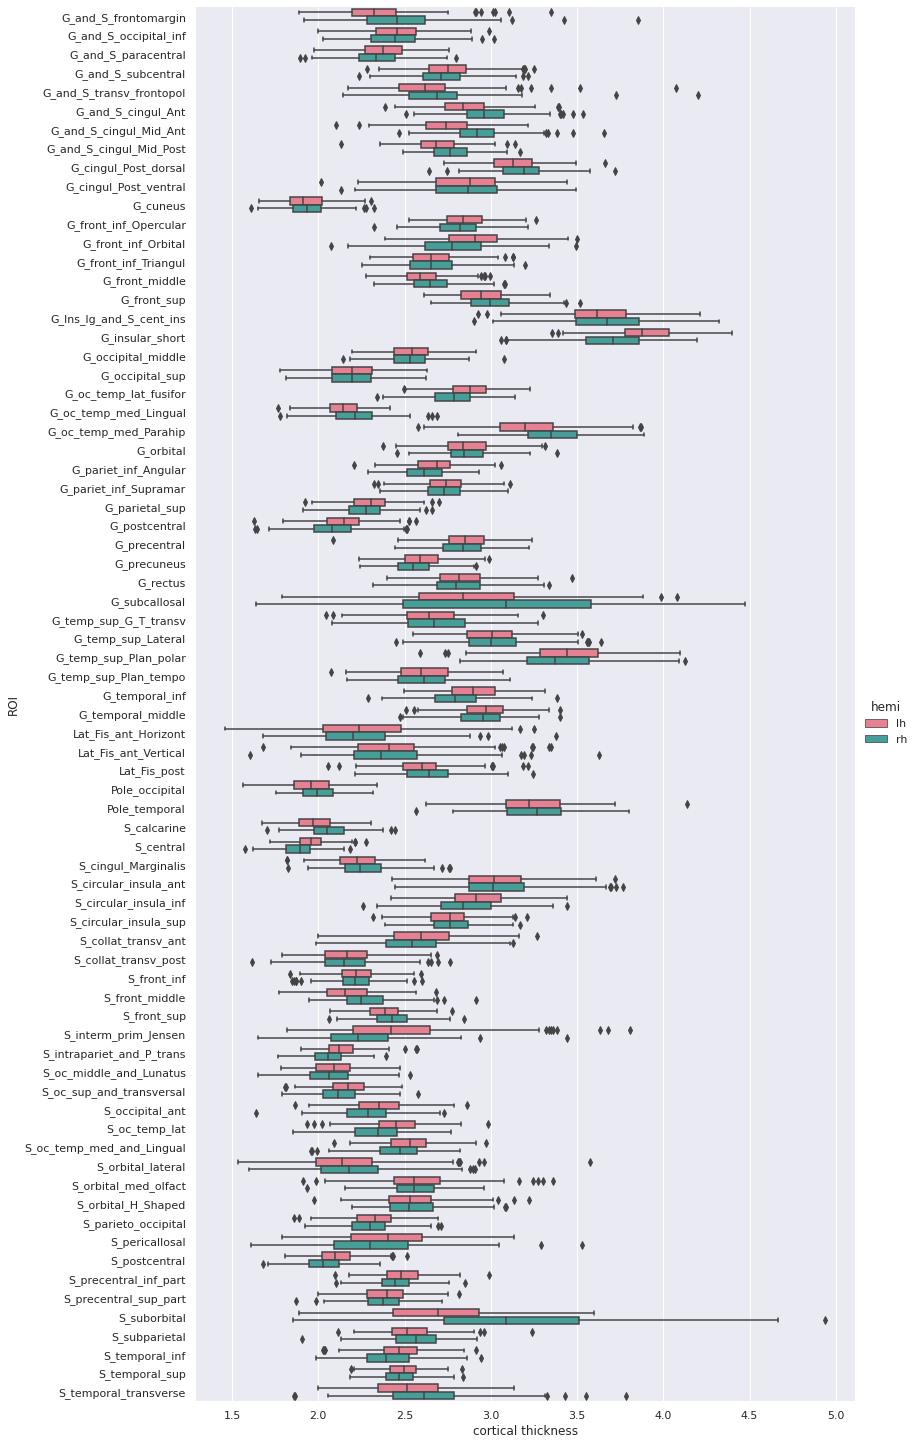

In [112]:
sns.set(font_scale=1)
g = sns.catplot(x='cortical thickness', y='ROI', hue='hemi', kind='box', aspect=0.6, 
                height=20, palette = sns.color_palette('husl',2), data=plot_long_df)

### How does cortical thickness change with age in young adults ?

#### Looking at a single ROI: e.g. cingulate mid ant

In [130]:
response = 'G_and_S_cingul_Mid_Ant' #'eTIV' 
predictor = 'age'

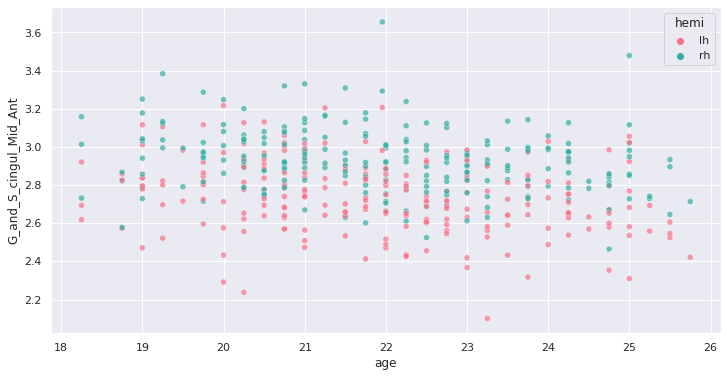

In [131]:
plt.figure(figsize=(12, 6))
g = sns.scatterplot(x=predictor, y=response, hue='hemi', alpha=0.7,
                    palette=sns.color_palette('husl',2), data=plot_df)

#### What about the stats ? Let's do a simple OLS regression.

In [132]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [134]:
response = 'G_and_S_cingul_Mid_Ant' #'eTIV' 
predictor = 'age'
hemi = 'lh'
hemi_df = fs_all_df[fs_all_df['hemi']==hemi]
covariates = 'eTIV + C(sex)' # [age, sex, BMI, education_category]
# Fit regression model
results = smf.ols(f"{response} ~ {predictor} + {covariates}", data=hemi_df).fit()
# Inspect the results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     G_and_S_cingul_Mid_Ant   R-squared:                       0.060
Model:                                OLS   Adj. R-squared:                  0.047
Method:                     Least Squares   F-statistic:                     4.728
Date:                    Thu, 03 Jun 2021   Prob (F-statistic):            0.00322
Time:                            02:41:24   Log-Likelihood:                 62.682
No. Observations:                     226   AIC:                            -117.4
Df Residuals:                         222   BIC:                            -103.7
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.2906      0.183     17.954      0.000       2.929       3.652
C(sex)[T.M]    -0.0097      0.033     -0.296      0.768      -0.074       0.055
age            -0.0258      0.007     -3.706      0.000      -0.040      -0.012
eTIV         1.612e-08   7.58e-08      0.213      0.832   -1.33e-07    1.66e-07
==============================================================================
Omnibus:                        2.038   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.361   Jarque-Bera (JB):                1.683
Skew:                          -0.157   Prob(JB):                        0.431
Kurtosis:                       3.282   Cond. No.                     2.03e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.03e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Now let's do it on all ROIs

In [135]:
def format_ols_results(res):
    ''' Converts statsmodels summary results (table2) 
    into dataframe with minimum usuful stat results'''
    results_summary = res.summary()
    results_as_html = results_summary.tables[1].as_html()
    res_df = pd.read_html(results_as_html, header=0, index_col=0)[0].reset_index()
    res_df['R2'] = res.rsquared
    res_df['R2_adj'] = res.rsquared_adj
    return res_df

In [136]:
# OLS result df
ols_df = pd.DataFrame()
predictor = 'age'
covariates = 'eTIV + C(sex)'
for hemi in ['lh','rh']:
    hemi_df = fs_all_df[fs_all_df['hemi']==hemi]
    for response in roi_cols:
        res = smf.ols(f"{response} ~ {predictor} + {covariates}", data=hemi_df).fit()
        res_df = format_ols_results(res)
        res_df['response'] = response
        res_df['hemi'] = hemi
        ols_df = ols_df.append(res_df)

In [137]:
ols_df

,index,coef,std err,t,P>|t|,[0.025,0.975],R2,R2_adj,response,hemi
0,Intercept,2.481300e+00,2.210000e-01,11.239,0.000,2.046000e+00,2.916000e+00,0.004184,-0.009273,G_and_S_frontomargin,lh
1,C(sex)[T.M],-7.200000e-03,3.900000e-02,-0.182,0.856,-8.500000e-02,7.100000e-02,0.004184,-0.009273,G_and_S_frontomargin,lh
2,age,-7.700000e-03,8.000000e-03,-0.921,0.358,-2.400000e-02,9.000000e-03,0.004184,-0.009273,G_and_S_frontomargin,lh
3,eTIV,1.781000e-08,9.140000e-08,0.195,0.846,-1.620000e-07,1.980000e-07,0.004184,-0.009273,G_and_S_frontomargin,lh
0,Intercept,2.593400e+00,1.650000e-01,15.732,0.000,2.269000e+00,2.918000e+00,0.018302,0.005035,G_and_S_occipital_inf,lh
...,...,...,...,...,...,...,...,...,...,...,...
3,eTIV,4.495000e-08,4.820000e-08,0.933,0.352,-5.000000e-08,1.400000e-07,0.075192,0.062694,S_temporal_sup,rh
0,Intercept,3.044100e+00,2.870000e-01,10.589,0.000,2.478000e+00,3.611000e+00,0.040983,0.028024,S_temporal_transverse,rh
1,C(sex)[T.M],-8.830000e-02,5.100000e-02,-1.718,0.087,-1.900000e-01,1.300000e-02,0.040983,0.028024,S_temporal_transverse,rh
2,age,-2.590000e-02,1.100000e-02,-2.370,0.019,-4.700000e-02,-4.000000e-03,0.040983,0.028024,S_temporal_transverse,rh


#### Let's have a look at significance and R squared

In [149]:
predictors = ['age']
all_rois_df = ols_df[ols_df['index'].isin(predictors)]
# Multiple comparison correction
n_comparisons = 2 * len(roi_cols) # 2 hemispheres
print(f"Bonferroni correction with {n_comparisons} multiple comparisons")
alpha = 0.05
alpha_corr = 0.05 / n_comparisons
print(f'Using corrected alpha threshold of {alpha_corr:5.4f}')
# Get significant ROIs and hemis
sign_rois = all_rois_df[all_rois_df['P>|t|'] < alpha_corr]['response'].values
sign_hemis = all_rois_df[all_rois_df['P>|t|'] < alpha_corr]['hemi'].values
print("")
print("Significant ROIs:")
print(list(zip(sign_rois, sign_hemis)))

Bonferroni correction with 148 multiple comparisons
Using corrected alpha threshold of 0.0003

Significant ROIs:
[('G_and_S_cingul_Mid_Ant', 'lh'), ('G_and_S_cingul_Mid_Post', 'lh'), ('G_front_inf_Opercular', 'lh'), ('G_front_middle', 'lh'), ('G_front_sup', 'lh'), ('G_occipital_middle', 'lh'), ('G_temp_sup_G_T_transv', 'lh'), ('S_circular_insula_sup', 'lh'), ('S_front_middle', 'lh'), ('S_front_sup', 'lh'), ('S_parieto_occipital', 'lh'), ('S_precentral_sup_part', 'lh'), ('S_temporal_sup', 'lh'), ('G_and_S_cingul_Mid_Post', 'rh'), ('G_cuneus', 'rh'), ('G_front_inf_Triangul', 'rh'), ('G_front_middle', 'rh'), ('G_front_sup', 'rh'), ('G_pariet_inf_Angular', 'rh'), ('G_precentral', 'rh'), ('G_rectus', 'rh'), ('G_temporal_middle', 'rh'), ('S_circular_insula_sup', 'rh'), ('S_front_sup', 'rh')]


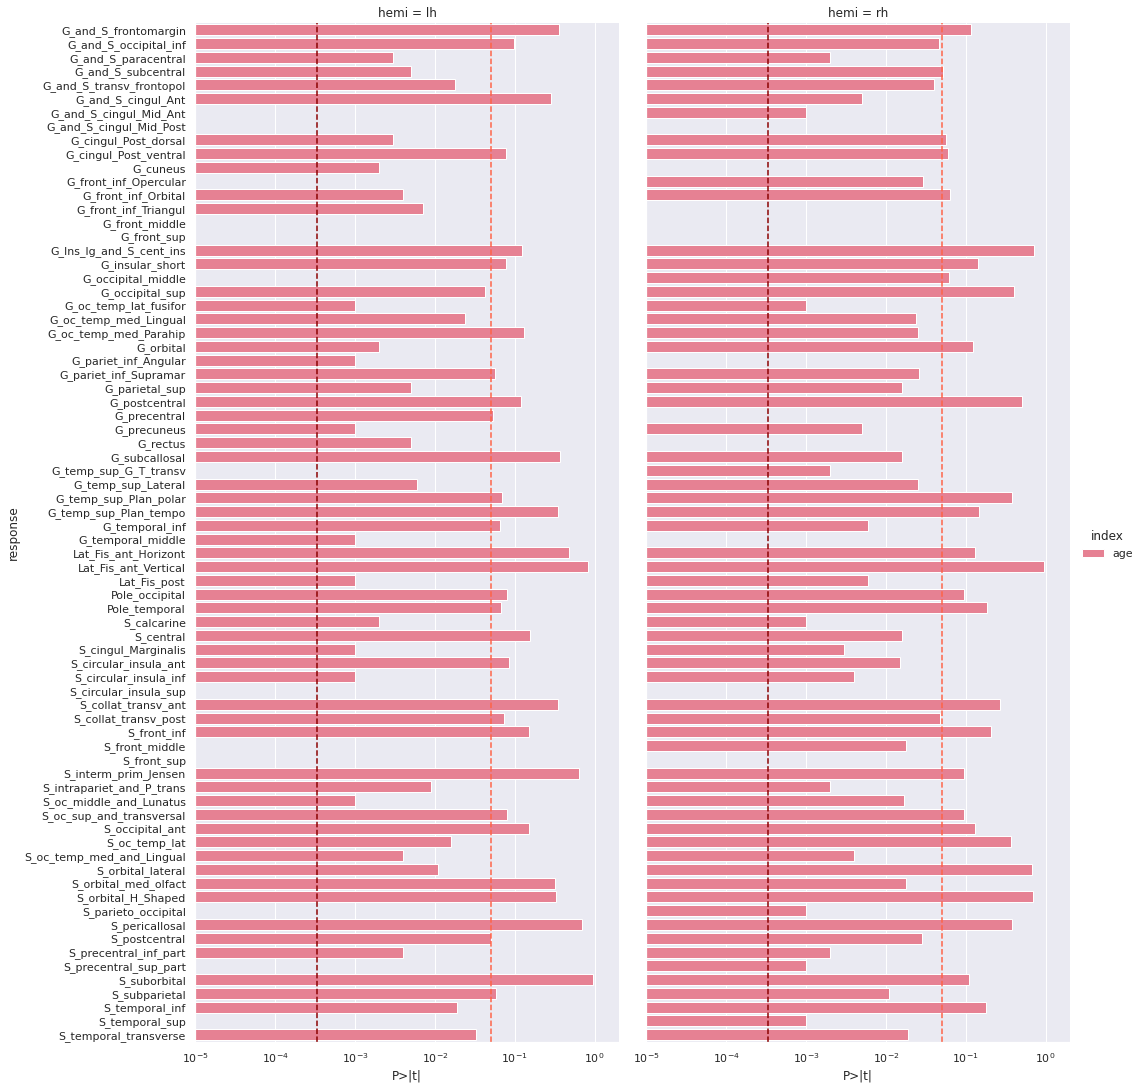

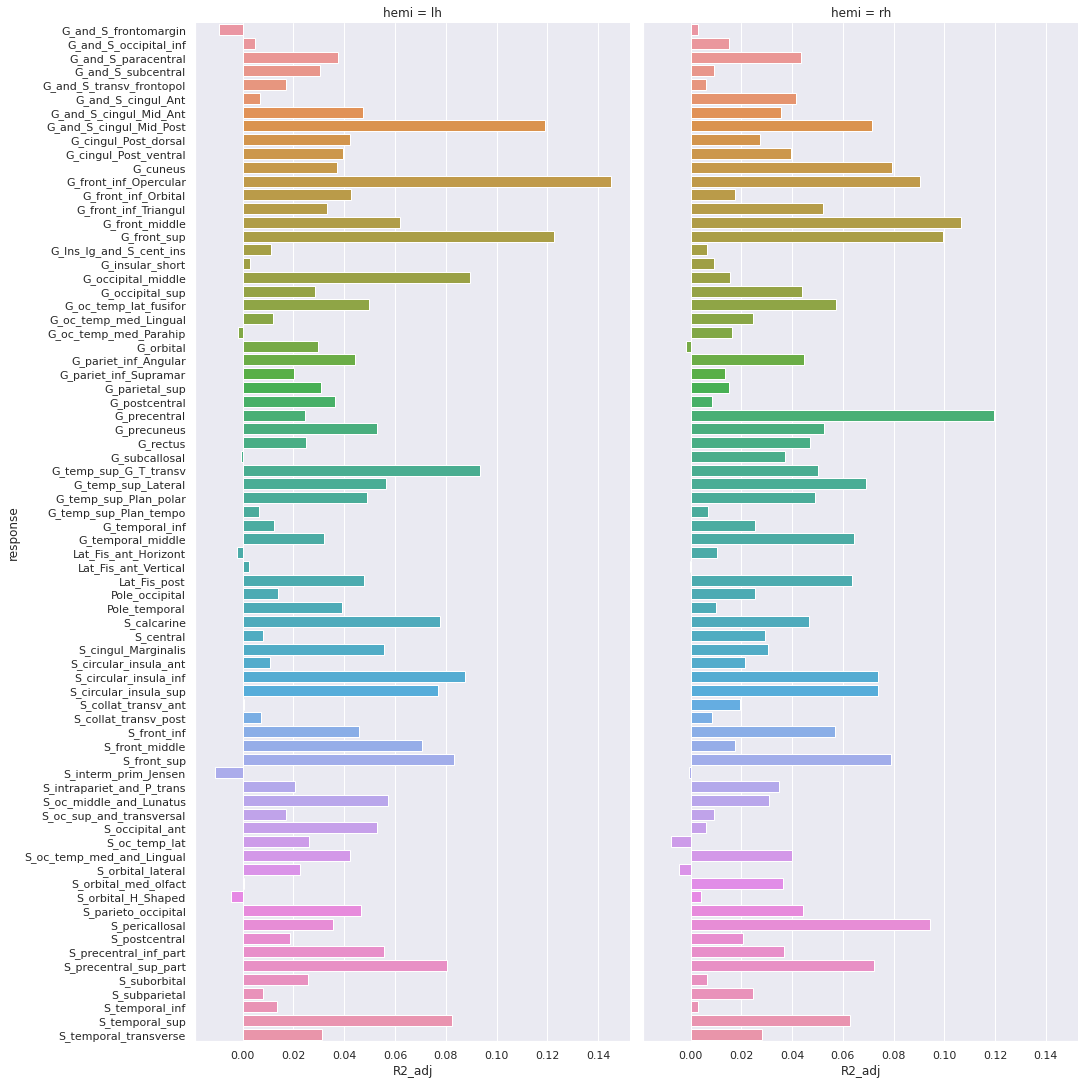

In [150]:
sns.set(font_scale=1)
g = sns.catplot(x='P>|t|', y='response', kind='bar', hue='index', col='hemi',
                aspect=0.5, height=15, palette=sns.color_palette('husl',2), data=all_rois_df)
g.set(xscale='log',xlim=(1e-5,2))
for ax in g.axes.flat:
    ax.axvline(alpha, ls='--',c='tomato')
    ax.axvline(alpha_corr, ls='--',c='darkred')

g = sns.catplot(x='R2_adj', y='response', col='hemi', kind='bar', 
                aspect=0.5, height=15, data=all_rois_df)

### Visualization

In [151]:
## Nilearn label strings for the Destrieux atlas are slightly different than what FreeSurfer uses. 
## Use this function to convert between them.

def map_fs_names_to_nilearn(stat_df, new2old_roinames):
    sign_rois = stat_df[stat_df['P>|t|'] < alpha_corr]['response'].values
    sign_hemis = stat_df[stat_df['P>|t|'] < alpha_corr]['hemi'].values

    nilearn_stats_lh = {}
    nilearn_stats_rh = {}
    for roi, hemi in zip(sign_rois, sign_hemis):
        nilearn_label = new2old_roinames[roi]
        nilearn_label = nilearn_label.replace('&', '_and_')
        #remove hemisphere prefix and thickness suffix from the name
        nilearn_label = nilearn_label.split('_',1)[1].rsplit('_',1)[0]
        t_stat = stat_df[(stat_df['response'] == roi) & (stat_df['hemi'] == hemi)]['t'].values[0]
        if hemi == 'lh':
            nilearn_stats_lh[nilearn_label] = t_stat
        elif hemi == 'rh':
            nilearn_stats_rh[nilearn_label] = t_stat
        else:
            print('unknown hemisphere')
    return nilearn_stats_lh, nilearn_stats_rh

In [152]:
nilearn_stats_lh, nilearn_stats_rh = map_fs_names_to_nilearn(all_rois_df, new2old_roinames)

In [154]:
#from nilearn import plotting
#from nilearn import surface
from nilearn import datasets

In [155]:
destrieux_atlas = datasets.fetch_atlas_surf_destrieux()
parcellation = destrieux_atlas['map_left']

# Retrieve fsaverage5 surface dataset for the plotting background. It contains
# the surface template as pial and inflated version and a sulcal depth maps
# which is used for shading
fsaverage = datasets.fetch_surf_fsaverage()

labels = destrieux_atlas['labels']
labels = [l.decode('utf-8') for l in labels]

In [156]:
stat_map_lh = np.zeros(parcellation.shape[0], dtype=int)
for roi, t_stat in nilearn_stats_lh.items():
    stat_labels = np.where(parcellation == labels.index(roi))[0]
    stat_map_lh[stat_labels] = t_stat

stat_map_rh = np.zeros(parcellation.shape[0], dtype=int)
for roi, t_stat in nilearn_stats_rh.items():
    stat_labels = np.where(parcellation == labels.index(roi))[0]
    stat_map_rh[stat_labels] = t_stat

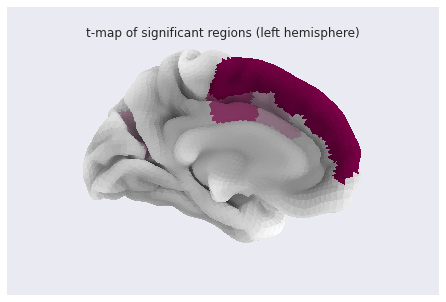

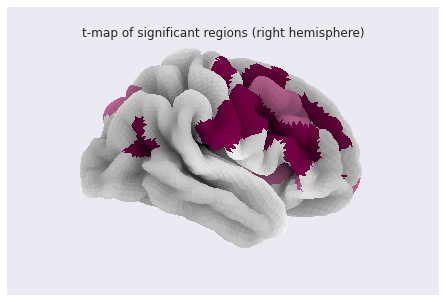

In [158]:
plotting.plot_surf_roi(fsaverage['pial_left'], roi_map=stat_map_lh,
                       hemi='left', view='medial', cmap='PiYG',
                       bg_map=fsaverage['sulc_left'], bg_on_data=True,
                       title='t-map of significant regions (left hemisphere)');

plotting.plot_surf_roi(fsaverage['pial_right'], roi_map=stat_map_rh,
                       hemi='left', view='medial', cmap='PiYG',
                       bg_map=fsaverage['sulc_right'], bg_on_data=True,
                       title='t-map of significant regions (right hemisphere)');

# VBM

In [163]:
course_demo = True

## Template

In [160]:
from nilearn.image import concat_imgs, mean_img

In [5]:
#data_dir = '../../data_VBM/selec/sub-031624_sub-031673/derivatives_mni/smriprep'
data_dir = '../../../../data/uva_aomic/derivatives/fmriprep'
proc_dir = '../../../../data/uva_aomic/derivatives/smri_course'

##### Template from GM probability maps in MNI space

In [169]:
GM_probmap_files = glob.glob(os.path.join(fmriprep_dir, "sub-*", "anat", "*MNI*GM_probseg.nii.gz"))

In [175]:
if not course_demo:
    GM_probmaps_4D_img = concat_imgs(GM_probmap_files)
    GM_probmap_mean_img = mean_img(GM_probmaps_4D_img)
else:
    GM_probmap_mean_img = nib.load(os.path.join(proc_dir, "GM226.nii.gz"))

##### Resample to 2-mm template

In [171]:
from nilearn.datasets import load_mni152_template
from nilearn.image import resample_to_img

In [176]:
if not course_demo:
    template = load_mni152_template()
    GM_probmap_mean_img_2mm = resample_to_img(GM_probmap_mean_img, template)
    # Save result
    GM_probmap_mean_img_2mm.to_filename(os.path.join(proc_dir, "GM226_2mm.nii.gz"))
else:
    GM_probmap_mean_img_2mm = nib.load(os.path.join(proc_dir, "GM226_2mm.nii.gz"))

In [174]:
GM_probmap_mean_img.shape

(91, 109, 91)

##### Plot results

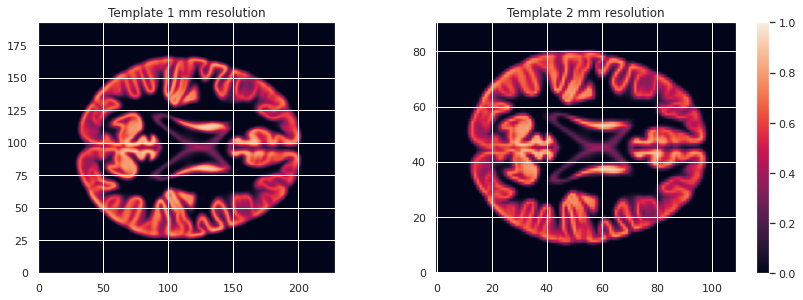

In [177]:
plt.figure(figsize=(12, 8))
n_plots = 2
n_cols = 2
# Plot first figure
plt.subplot(n_plots, n_cols, 1)
plt.imshow(GM_probmap_mean_img.get_fdata()[:, :, 100], origin="lower", vmin=0, vmax=1)
plt.title('Template 1 mm resolution')
# Plot first figure
plt.subplot(n_plots, n_cols, 2)
plt.imshow(GM_probmap_mean_img_2mm.get_fdata()[:, :, 47], origin="lower", vmin=0, vmax=1)
plt.title('Template 2 mm resolution')
plt.colorbar();
plt.tight_layout() # Magic command to clean the overall plot

### Compute deformations (do not run in this notebook)

```bash
#NATIVE_GM_MAPS=(data/derivatives_mni/smriprep/sub-*/anat/sub-+([0-9])_label-GM_probseg.nii.gz)
NATIVE_GM_MAPS=(data/derivatives/fmriprep/sub-*/anat/sub-+([0-9])_label-GM_probseg.nii.gz)
for GM_MAP in ${NATIVE_GM_MAPS[@]}; do 
    SUBJ_NAME=${GM_MAP%%_label*}
    fsl_reg ${GM_MAP} GM226_2mm.nii.gz \
            data/derivatives/smri_course/${SUBJ_NAME}_space-GM226_label-GM_probseg \
            -fnirt "--config=GM_2_MNI152GM_2mm.cnf --jout=${SUBJ_NAME}_J"
done
```

### Estimate GM modulated maps

In [178]:
from nilearn.image import math_img, smooth_img

In [60]:
subj_dirs = sorted(glob.glob(os.path.join(proc_dir, "sub-*")))
# Calculating 
for subj_dir in subj_dirs:
    subj_name = os.path.basename(subj_dir)
    print(f"==={subj_name}")
    # Get GM probability map in template space
    warped_GM_file = os.path.join(subj_dir, f"{subj_name}_space-GM226_label-GM_probseg.nii.gz")
    warped_GM = nib.load(warped_GM_file)
    # Get scaling factors (trace of Jacobian)
    J_map_file = os.path.join(subj_dir, f"{subj_name}_J.nii.gz")
    J_map = nib.load(J_map_file)
    # Compute modulated map
    modulated_map = math_img("img1 * img2", img1=warped_GM, img2=J_map)
    # Save modulated image
    modulated_map_file = os.path.join(subj_dir, f"{subj_name}_space-GM226_label-GM_mod.nii.gz")
    modulated_map.to_filename(modulated_map_file)

===sub-0001
===sub-0002
===sub-0003
===sub-0004
===sub-0005
===sub-0006
===sub-0007
===sub-0008
===sub-0009
===sub-0010
===sub-0011
===sub-0012
===sub-0013
===sub-0014
===sub-0015
===sub-0016
===sub-0017
===sub-0018
===sub-0019
===sub-0020
===sub-0021
===sub-0022
===sub-0023
===sub-0024
===sub-0025
===sub-0026
===sub-0027
===sub-0028
===sub-0029
===sub-0030
===sub-0031
===sub-0032
===sub-0033
===sub-0034
===sub-0035
===sub-0036
===sub-0037
===sub-0038
===sub-0039
===sub-0040
===sub-0041
===sub-0042
===sub-0043
===sub-0044
===sub-0045
===sub-0046
===sub-0047
===sub-0048
===sub-0049
===sub-0050
===sub-0051
===sub-0052
===sub-0053
===sub-0054
===sub-0055
===sub-0056
===sub-0057
===sub-0058
===sub-0059
===sub-0060
===sub-0061
===sub-0062
===sub-0063
===sub-0064
===sub-0065
===sub-0066
===sub-0067
===sub-0068
===sub-0069
===sub-0070
===sub-0071
===sub-0072
===sub-0073
===sub-0074
===sub-0075
===sub-0076
===sub-0077
===sub-0078
===sub-0079
===sub-0080
===sub-0081
===sub-0082
===sub-0083
===s

#### Some processing before stats

##### Create 4D file

In [181]:
if not course_demo:
    modulated_maps_4D_file = os.path.join(proc_dir, "cohort_space-GM226_label-GM_mod.nii.gz")
    modulated_map_files = sorted(glob.glob(os.path.join(proc_dir, "sub*", "*GM_mod.nii.gz")))
    modulated_maps_4D = concat_imgs(modulated_map_files)
    modulated_maps_4D.to_filename(modulated_maps_4D_file)

In [183]:
modulated_maps_mean_file = os.path.join(proc_dir, "cohort_space-GM226_label-GM_mod_mean.nii.gz")
if not course_demo:
    modulated_maps_mean = mean_img(modulated_maps_4D)
    modulated_maps_mean.to_filename(modulated_maps_mean_file)
else:
    modulated_maps_mean = nib.load(modulated_maps_mean_file)

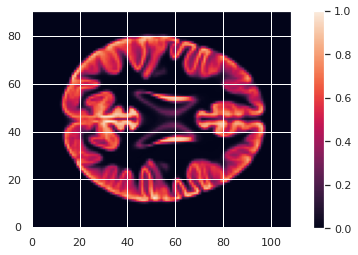

In [184]:
plt.figure(figsize=(8, 4))
plt.imshow(modulated_maps_mean.get_fdata()[:, :, 48], origin="lower", vmin=0, vmax=1)
plt.colorbar();

##### Create GM mask

In [185]:
GM_mask = math_img('img > 0.05', img=modulated_maps_mean)
GM_mask.to_filename(os.path.join(proc_dir, "GM226_mask.nii.gz"))

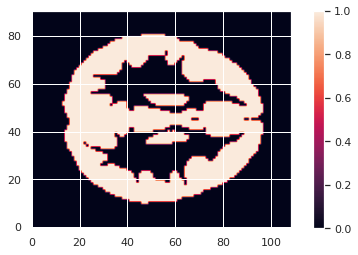

In [187]:
plt.figure(figsize=(8, 4))
plt.imshow(GM_mask.get_fdata()[:, :, 50], origin="lower", vmin=0, vmax=1)
plt.colorbar();

#### Design matrix

In [40]:
design_matrix = subjects_info[["participant_id", "age", "sex"]].set_index("participant_id")
design_matrix = pd.get_dummies(design_matrix, columns=["sex"], drop_first=True)
design_matrix["intercept"] = 1
design_matrix

,age,sex_M,intercept
participant_id,,,
sub-0001,25.50,1,1
sub-0002,23.25,0,1
sub-0003,25.00,0,1
sub-0004,20.00,0,1
sub-0005,24.75,1,1
...,...,...,...
sub-0222,22.00,0,1
sub-0223,20.75,0,1
sub-0224,21.75,1,1


#### Using nilearn second level glm module

In [182]:
design_matrix

,age,sex_M,intercept
participant_id,,,
sub-0001,25.50,1,1
sub-0002,23.25,0,1
sub-0003,25.00,0,1
sub-0004,20.00,0,1
sub-0005,24.75,1,1
...,...,...,...
sub-0222,22.00,0,1
sub-0223,20.75,0,1
sub-0224,21.75,1,1


In [191]:
from nilearn.glm.second_level import SecondLevelModel

/opt/conda/shared/envs/ni38/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [200]:
from nilearn.glm import threshold_stats_img

In [195]:
second_level_model = SecondLevelModel(smoothing_fwhm=3.0, mask_img=GM_mask)
second_level_model.fit(modulated_map_files,
                       design_matrix=design_matrix)

SecondLevelModel(mask_img=<nibabel.nifti1.Nifti1Image object at 0x7f4c2650ffd0>,
                 smoothing_fwhm=3.0)

In [199]:
z_map = second_level_model.compute_contrast(second_level_contrast=[1, 0, 0],
                                            output_type='z_score')

In [230]:
z_map_thr, threshold = threshold_stats_img(z_map, mask_img=GM_mask, alpha=.05, 
                                           height_control='fpr', cluster_threshold=50)

1.9599639845400545

In [ ]:
display = plotting.plot_stat_map(
    z_map, threshold=threshold, colorbar=True, display_mode='z',
    cut_coords=[-4, 26],
    title='age effect on grey matter density (FDR = .05)')
plotting.show()

#### Other method

In [160]:
from nilearn.input_data import NiftiMasker

In [161]:
from nilearn.mass_univariate import permuted_ols

In [162]:
nifti_masker = NiftiMasker(
    mask_img=GM_mask,
    standardize=False,
    smoothing_fwhm=3) 

In [164]:
gm_maps_masked = nifti_masker.fit_transform(modulated_map_files)

In [73]:
#confounding_vars = np.hstack((design_matrix["sex_M"].values.reshape((1,-1)).T,
#                              np.ones((design_matrix["age"].shape[0], 1))))

In [165]:
age_predictor = design_matrix["age"].values.reshape((1,-1)).T

In [166]:
sex_confound = design_matrix["sex_M"].values.reshape((1,-1)).T

In [167]:
gm_maps_masked.shape

(226, 196314)

In [176]:
# Statistical inference
neg_log_pvals, t_scores_original_data, _ = permuted_ols(
    age_predictor, gm_maps_masked, sex_confound, two_sided_test=True,
    model_intercept=True, n_perm=10000, verbose=1,  n_jobs=40) 
signed_neg_log_pvals = neg_log_pvals * np.sign(t_scores_original_data)
signed_neg_log_pvals_unmasked = nifti_masker.inverse_transform(signed_neg_log_pvals)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of  40 | elapsed:  4.0min remaining: 75.5min
[Parallel(n_jobs=40)]: Done  40 out of  40 | elapsed:  5.8min finished


In [174]:
permuted_ols?

In [169]:
from nilearn.plotting import plot_stat_map

/opt/conda/shared/envs/ni38/lib/python3.8/site-packages/nilearn/reporting/html_document.py:56: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



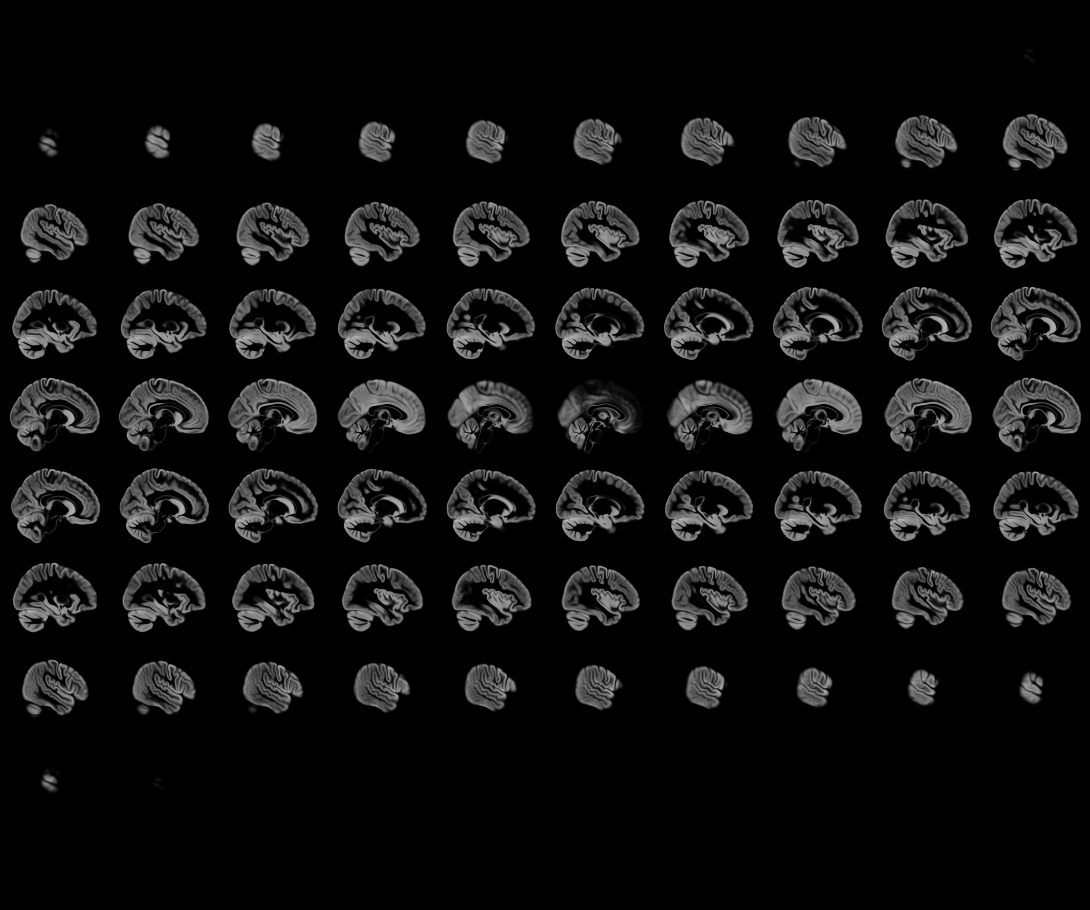
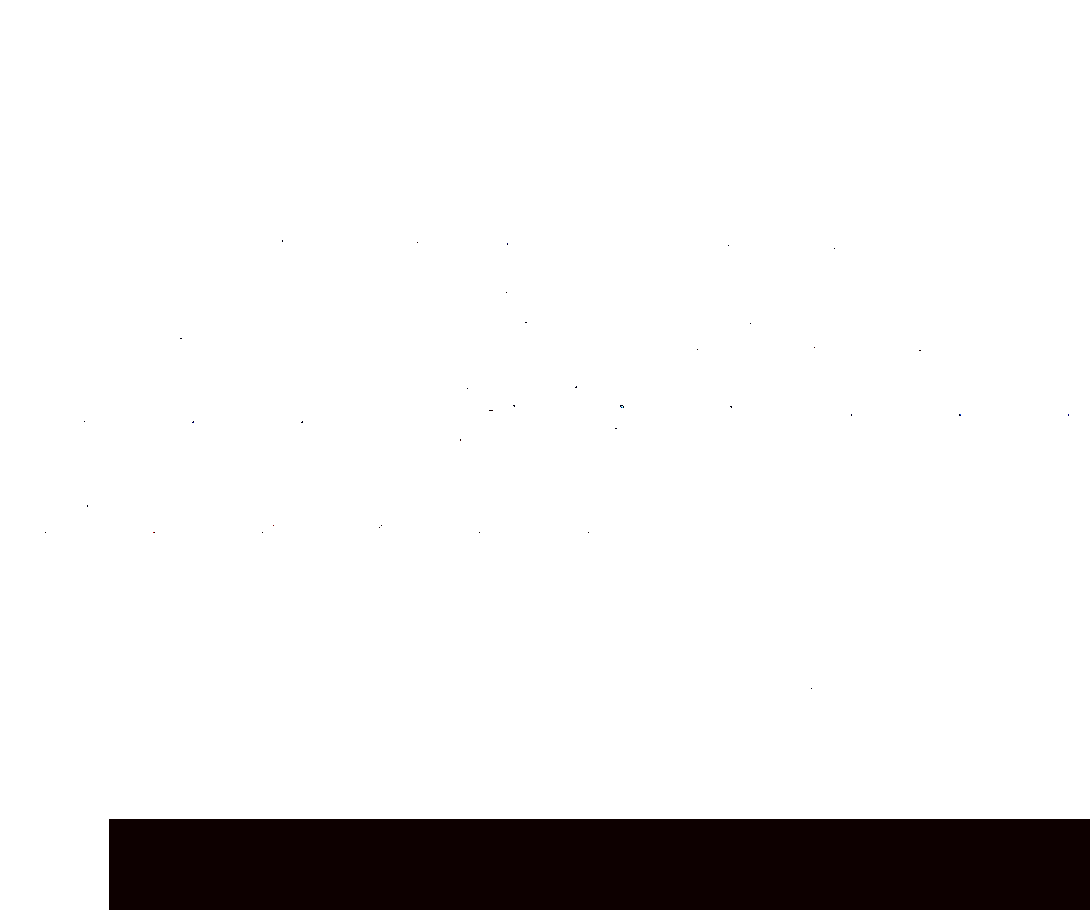

In [181]:
plotting.view_img(signed_neg_log_pvals_unmasked, bg_img=modulated_maps_mean)

In [178]:
tscores_unmasked2 = nifti_masker.inverse_transform(t_scores_original_data)

/opt/conda/shared/envs/ni38/lib/python3.8/site-packages/nilearn/reporting/html_document.py:56: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



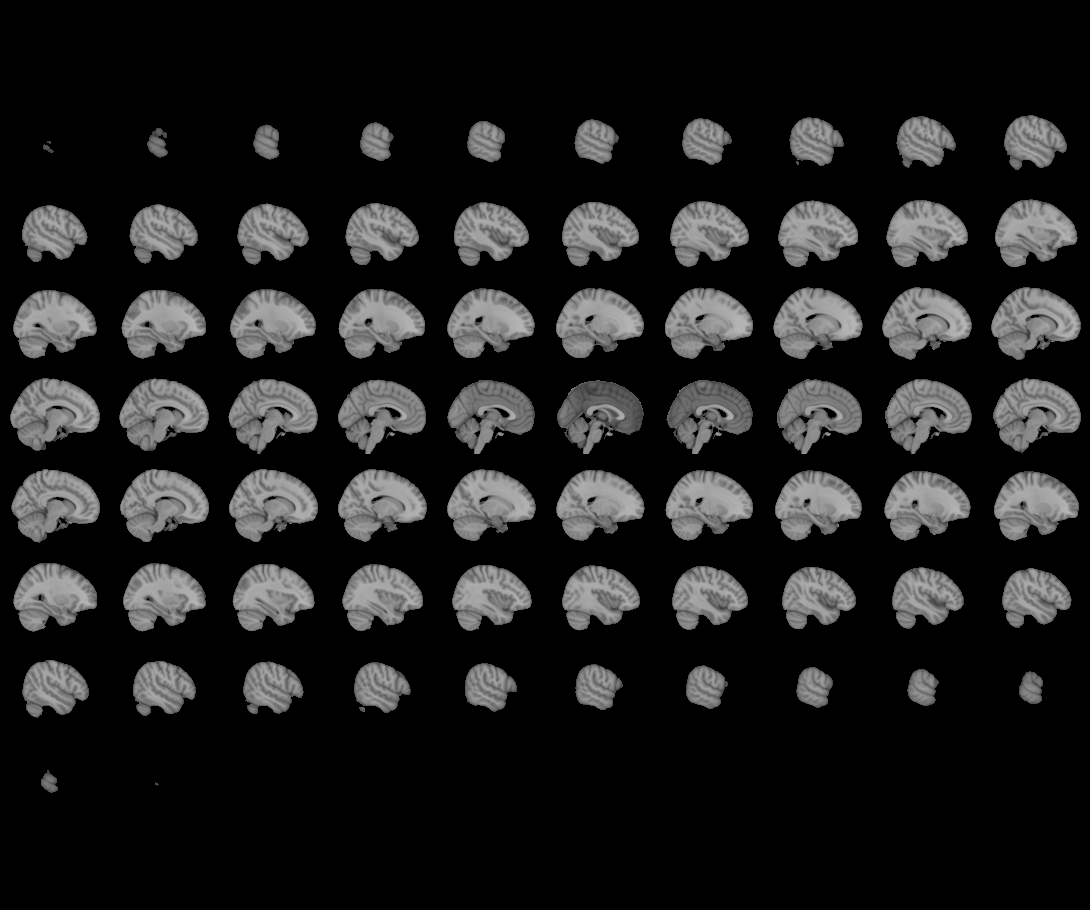
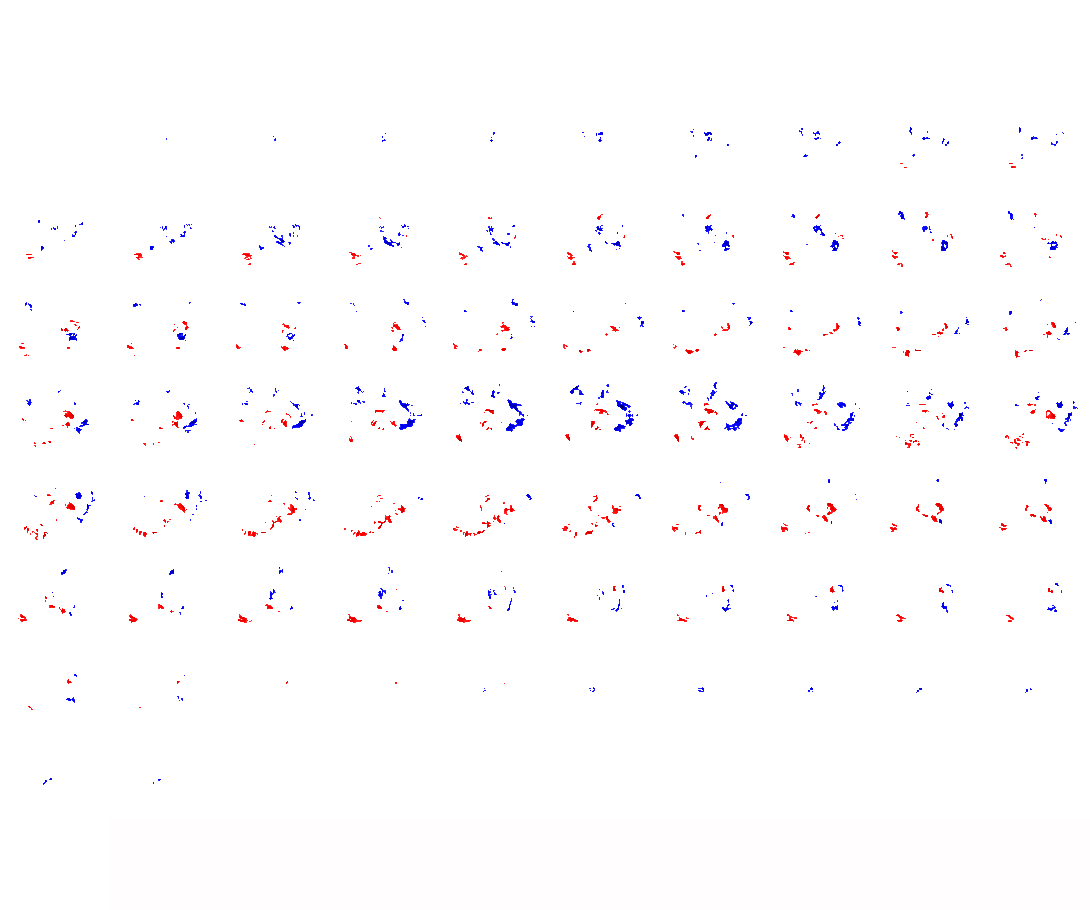

In [231]:
plotting.view_img(z_map_thr, threshold=threshold, cmap="seismic")

In [222]:
plotting.view_img?


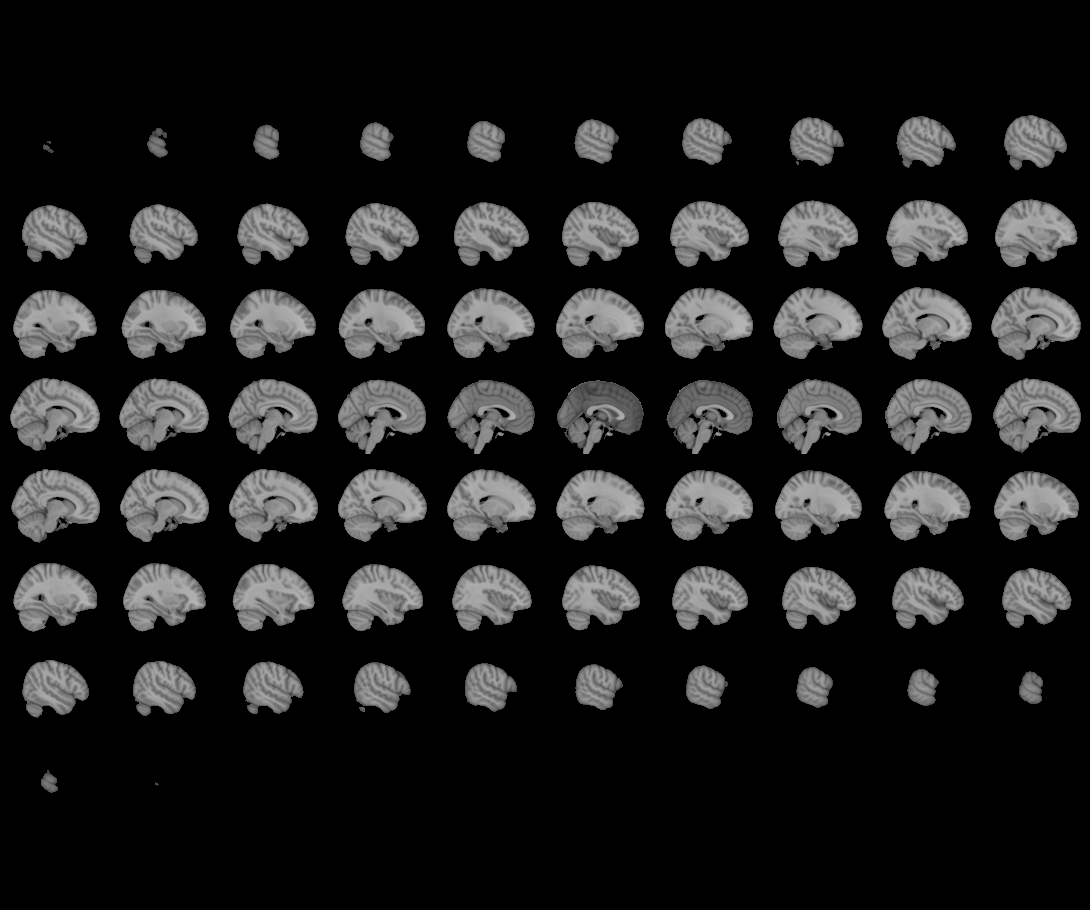
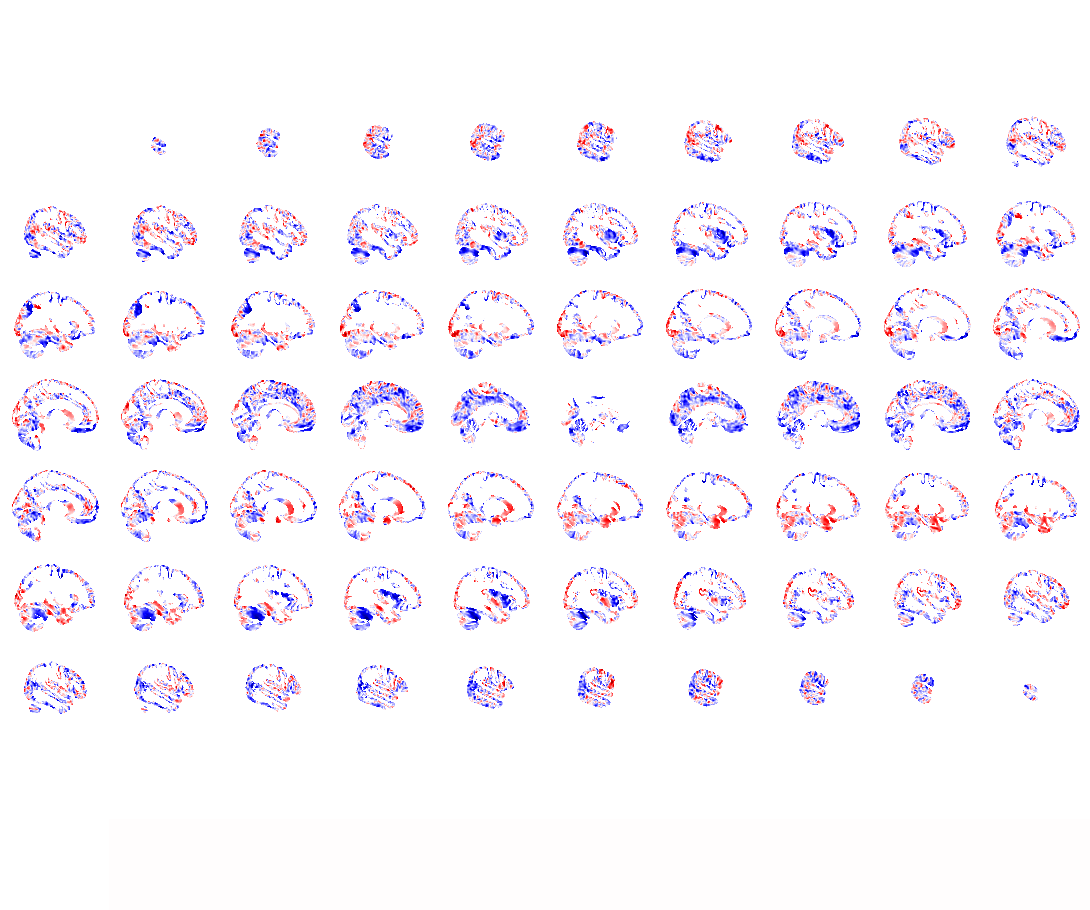

In [141]:
plotting.view_img(tscores_unmasked, cmap="seismic")

In [152]:
plotting.view_img?

In [109]:
# Show results
threshold = -np.log10(0.5)  # 10% corrected
fig = plt.figure(figsize=(5.5, 7.5), facecolor='k')
plot_stat_map(signed_neg_log_pvals_unmasked, bg_img=modulated_maps_mean_img,
              threshold=threshold, cmap=plt.cm.RdBu_r,
              display_mode='z', cut_coords=[-10],
              figure=fig)

NameError: name 'modulated_maps_mean_img' is not defined

<Figure size 396x540 with 0 Axes>